
## Fair Autoencoder for Bias Reduction in Latent Space

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load the CSV file into a DataFrame
data = pd.read_csv('wholevalue.csv')

In [9]:
data.head()

,Gender,Age,12th marks %,rural/ urban area,Were you prepared to take this course based on prior coursework?,Average Weekly Time Spent,Average Course Outcome Level,Average Effort in Course Outcomes,Average Satisfaction,Stratergies,Average Marks Given,Low mark reason,Faculty Concern,Outside help,Your overall feedback
0,1,2,34,1,1,2,5,5,2,2,2,1,0,0,0
1,0,6,33,1,0,5,4,6,1,2,1,1,0,0,1
2,1,4,12,0,1,4,4,0,1,2,2,3,1,1,0
3,0,4,26,1,1,1,5,7,1,3,3,1,0,0,0
4,1,2,21,1,0,1,5,9,2,3,3,1,0,0,0


In [10]:
# Separate features and target (assuming 'Gender' as the sensitive attribute and 'Course Outcome Level' as the target)
sensitive_attr = 'Gender'
target = 'Average Course Outcome Level'

X = data.drop(columns=[sensitive_attr, target])
y = data[target]
gender = data[sensitive_attr]

In [ ]:
from scipy.stats import chi2_contingency  # Ensure this import statement is included


# Define the sensitive attribute and target variable
sensitive_attr = 'Gender'
target = 'Average Course Outcome Level'

# Check if target outcomes differ significantly by gender using a contingency table and Chi-squared test
contingency_table = pd.crosstab(data[sensitive_attr], data[target])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print("Contingency Table:\n", contingency_table)
print("\nChi-squared Test Statistic:", chi2)
print("p-value:", p_value)


# Calculate Demographic Parity (average target outcome by gender)
demographic_parity = data.groupby(sensitive_attr)[target].mean()
print("\nDemographic Parity (mean target by gender):\n", demographic_parity)

# Calculate Statistical Parity Difference (absolute difference in mean outcomes between genders)
statistical_parity_difference = abs(demographic_parity.max() - demographic_parity.min())
print("\nStatistical Parity Difference:", statistical_parity_difference)

# Disparate Impact Ratio (ratio of minimum to maximum mean outcomes across genders)
disparate_impact_ratio = demographic_parity.min() / demographic_parity.max()
print("\nDisparate Impact Ratio:", disparate_impact_ratio)

Contingency Table:
 Average Course Outcome Level  0  1   2   3   4   5
Gender                                            
0                             1  4   6  10  59  75
1                             1  0  18   9  39  66

Chi-squared Test Statistic: 13.104645807795107
p-value: 0.022417611636889948

Demographic Parity (mean target by gender):
 Gender
0    4.23871
1    4.12782
Name: Average Course Outcome Level, dtype: float64

Statistical Parity Difference: 0.11089012854717417

Disparate Impact Ratio: 0.9738387063549284

Significant difference in target outcomes by gender (potential bias detected).


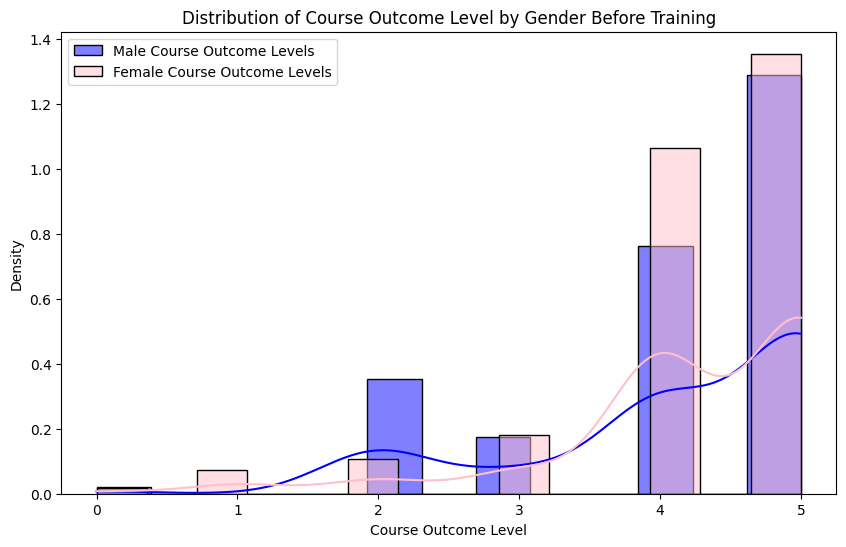

In [15]:
# Plot demographic parity before training
plt.figure(figsize=(10, 6))
sns.histplot(data[target][data[sensitive_attr] == 1], color='blue', label='Male Course Outcome Levels', kde=True, stat="density")
sns.histplot(data[target][data[sensitive_attr] == 0], color='pink', label='Female Course Outcome Levels', kde=True, stat="density")
plt.title("Distribution of Course Outcome Level by Gender Before Training")
plt.xlabel("Course Outcome Level")
plt.ylabel("Density")
plt.legend()
plt.show()

In [16]:
# Train-test split
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(X, y, gender, test_size=0.2, random_state=42)


In [17]:
# Standardize the feature values
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 10  # Dimensionality of the latent space

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoder = Dense(encoding_dim, activation='relu')(input_layer)
encoder = Dense(encoding_dim // 2, activation='relu')(encoder)

# Latent space with dropout to prevent overfitting and introduce fairness
latent_space = Dense(encoding_dim // 4, activation='relu', name="latent")(encoder)
latent_dropout = Dropout(0.2)(latent_space)

# Decoder
decoder = Dense(encoding_dim // 2, activation='relu')(latent_dropout)
decoder = Dense(encoding_dim, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Define the adversary model to predict gender from latent space (to minimize gender information)
adversary_input = Input(shape=(encoding_dim // 4,))
adversary_hidden = Dense(encoding_dim // 2, activation='relu')(adversary_input)
adversary_output = Dense(1, activation='sigmoid')(adversary_hidden)
adversary_model = Model(inputs=adversary_input, outputs=adversary_output)

In [19]:
# Custom loss for the autoencoder to minimize reconstruction error
def autoencoder_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

# Custom adversary loss to penalize gender predictability in the latent space
def adversary_loss(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred)

# Compile models
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=autoencoder_loss)
adversary_model.compile(optimizer=Adam(learning_rate=0.001), loss=adversary_loss)

In [21]:
epochs = 500
batch_size = 32

for epoch in range(epochs):
    # Train the autoencoder
    autoencoder_loss_value = autoencoder.train_on_batch(X_train, X_train)
    
    # Get the latent representation
    latent_output = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("latent").output)
    latent_train = latent_output.predict(X_train)
    
    # Train the adversary on latent representation and gender
    adversary_loss_value = adversary_model.train_on_batch(latent_train, gender_train)
    
    # Print progress
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} - Autoencoder Loss: {autoencoder_loss_value:.4f} - Adversary Loss: {adversary_loss_value:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 0/500 - Autoencoder Loss: 1.1045 - Adversary Loss: 0.6905
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 10/500 - Autoencoder Loss: 1.1015 - Adversary Loss: 0.6905
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Epoch 20/500 - Autoencoder Loss: 1.0986 - Adversary Loss: 0.6905
8/8 ━━━

In [11]:
# Evaluate reconstruction on test data
reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(reconstructed - X_test), axis=1)
print("Average Reconstruction Error:", np.mean(reconstruction_error))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step 
Average Reconstruction Error: 0.9031326154893221


In [12]:
# Get latent representation for the test set
latent_test = latent_output.predict(X_test)

# Test adversary accuracy on predicting gender from the latent representation
gender_pred = adversary_model.predict(latent_test)
gender_pred = (gender_pred > 0.5).astype(int)
adversary_accuracy = accuracy_score(gender_test, gender_pred)
print("Adversary Accuracy (Lower is better for fairness):", adversary_accuracy)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Adversary Accuracy (Lower is better for fairness): 0.46551724137931033


In [ ]:
# Downstream task: Predict Course Outcome Level from the latent representation
# Let's define a simple classifier to predict 'Average Course Outcome Level' using the latent space

# Define classifier model
classifier_input = Input(shape=(encoding_dim // 4,))
classifier_hidden = Dense(encoding_dim // 2, activation='relu')(classifier_input)
classifier_output = Dense(1, activation='linear')(classifier_hidden)
classifier_model = Model(inputs=classifier_input, outputs=classifier_output)

# Compile and train the classifier
classifier_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
classifier_model.fit(latent_train, y_train, epochs=50, batch_size=32, verbose=0)

# Predictions on test data
y_pred = classifier_model.predict(latent_test)

# Demographic parity: Calculate mean predictions for each gender
male_predictions = y_pred[gender_test == 1]
female_predictions = y_pred[gender_test == 0]

# Calculate the means for demographic parity
male_mean_pred = np.mean(male_predictions)
female_mean_pred = np.mean(female_predictions)

# Calculate the absolute difference to assess demographic parity
demographic_parity_diff = abs(male_mean_pred - female_mean_pred)

print(f"Demographic Parity - Male Mean Prediction: {male_mean_pred:.3f}")
print(f"Demographic Parity - Female Mean Prediction: {female_mean_pred:.3f}")
print(f"Absolute Difference (Should be close to 0 for parity): {abs(male_mean_pred - female_mean_pred):.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Demographic Parity - Male Mean Prediction: 2.738
Demographic Parity - Female Mean Prediction: 2.560
Absolute Difference (Should be close to 0 for parity): 0.177

Potential bias detected: Significant difference in predictions between genders.


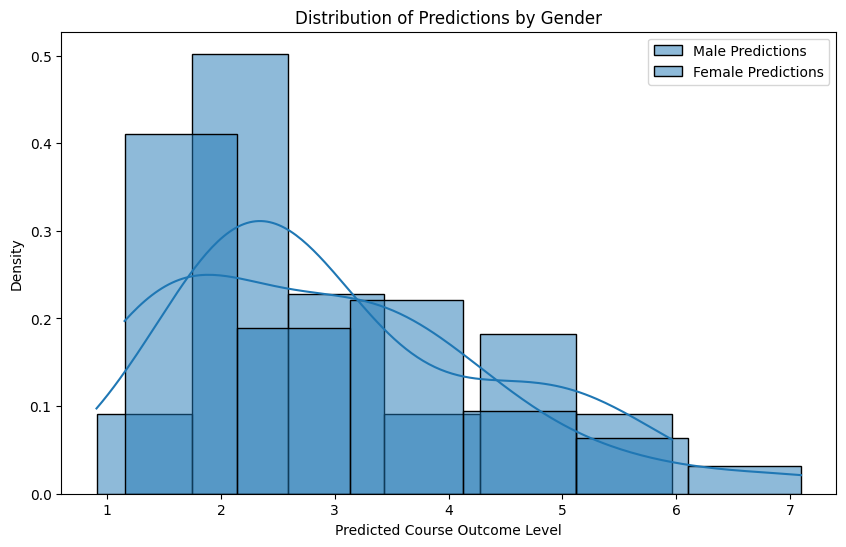

In [15]:
# Plot distributions of predictions for each gender to visualize demographic parity
plt.figure(figsize=(10, 6))
sns.histplot(male_predictions, color='blue', label='Male Predictions', kde=True, stat="density")
sns.histplot(female_predictions, color='pink', label='Female Predictions', kde=True, stat="density")
plt.title("Distribution of Predictions by Gender")
plt.xlabel("Predicted Course Outcome Level")
plt.ylabel("Density")
plt.legend()
plt.show()

/var/folders/vj/bzq0bvbn591gs49t9sxbbd740000gn/T/ipykernel_8918/3776801916.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Male", "Female"], y=[male_mean_pred, female_mean_pred], palette=["blue", "pink"])


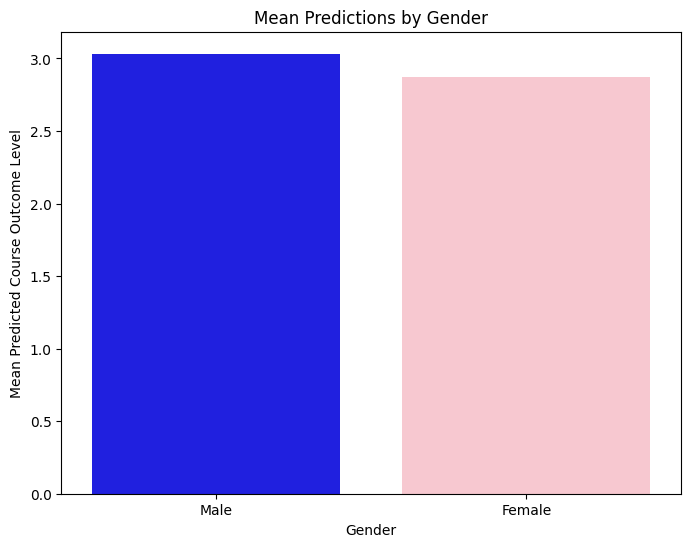

In [16]:
# Bar plot of mean predictions to show demographic parity visually
plt.figure(figsize=(8, 6))
sns.barplot(x=["Male", "Female"], y=[male_mean_pred, female_mean_pred], palette=["blue", "pink"])
plt.title("Mean Predictions by Gender")
plt.xlabel("Gender")
plt.ylabel("Mean Predicted Course Outcome Level")
plt.show()